In [561]:
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [562]:
#### Preprocecing ###

In [563]:
jh_dir = "../../COVID-19"

In [564]:
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [565]:
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()

In [566]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()

In [567]:
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [568]:
### Data Preparation ###

In [569]:
country = 'Japan'
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-03')
C0 = confirmed.loc[epoch:last, country].values
R0 = (recovered).loc[epoch:last, country].values
D0 = death.loc[epoch:last, country].values
P = 12000_0000
iteration=2000
repeat = 1000

In [570]:
data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0, 'q0':0.2, 'b_beta_0':0.1}

In [571]:
data['R0']

array([   0,    0,    0,    0,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    4,    9,    9,
          9,    9,   12,   12,   12,   13,   18,   18,   22,   22,   22,
         22,   22,   22,   22,   22,   32,   32,   32,   43,   43,   43,
         46,   76,   76,   76,  101,  118,  118,  118,  118,  118,  144,
        144,  144,  150,  191,  232,  235,  235,  285,  310,  359,  372,
        404,  424,  424,  424,  472,  472,  514,  514,  514,  575,  592,
        622,  632,  685,  762,  762,  784,  799,  853,  901,  935, 1069,
       1159, 1159, 1239, 1356, 1494, 1530, 1656, 1809, 1899, 1899, 2368,
       2460, 2975, 3205, 3981])

In [572]:
### Model ###

In [573]:
sm_const = pystan.StanModel(file="const.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9aa3fa7c41685d5a0b13564658e4e3f NOW.


In [574]:
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_17a7257d73a110f9f91071daab0eacbd NOW.


In [575]:
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47264f333afa504619cc2028921c49d2 NOW.


In [576]:
# Train the model and generate samples
inits = 'random'
fit_const = sm_const.sampling(data=data, iter=iteration, init=inits)
fit_const


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_e9aa3fa7c41685d5a0b13564658e4e3f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  10.02    2.63   4.52   3.81   3.87  10.51  13.25  18.58      3    1.7
b           0.1    0.01   0.02   0.09   0.09   0.09   0.11   0.13      2  18.61
q           1.0  1.9e-3 2.7e-3   0.99   0.99    1.0    1.0    1.0      2   6.11
NI[1]      1.07     0.2   0.74    0.1   0.57   0.78    1.5   2.92     13    1.1
NI[2]       2.4    1.34    2.0   0.11   0.87   1.61   5.21   5.79      2   3.03
NI[3]      1.37    0.01   0.73   0.14   0.92   1.33   1.71   3.13   3539    1.0
NI[4]       2.3    0.01   0.79   0.85   1.89   2.22   2.65   4.18   4006    1.0
NI[5]      1.47    0.08   0.81   0.14   1.06   1.21    1.9    3.4    116   1.02
NI[6]      2.85    0.12   0.86   1.36   2.42   2.53

In [577]:
# Train the model and generate samples
inits = 'random'
fit_every = sm_every.sampling(data=data, iter=iteration, init=inits)
fit_every


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.67    0.27   6.07    1.1   2.53   4.01   6.63  20.75    495   1.01
b_beta     0.01  3.0e-4 4.2e-3 8.2e-3   0.01   0.01   0.02   0.02    187    1.0
b[1]       0.07  3.1e-3   0.07 1.5e-3   0.02   0.04   0.11   0.24    490   1.01
b[2]        0.1  2.9e-3   0.07 6.4e-3   0.04   0.09   0.15   0.25    558   1.01
b[3]       0.12  2.7e-3   0.07   0.02   0.07   0.12   0.17   0.27    610   1.01
b[4]       0.14  2.4e-3   0.06   0.04    0.1   0.14   0.18   0.27    606    1.0
b[5]       0.15  2.3e-3   0.06   0.05   0.11   0.15   0.19   0.28    590    1.0
b[6]       0.16  2.2e-3   0.05   0.07   0.13   0.16   0.19   0.28    591    1.0
b[7]       0.17  2.1e-3   0.05   0.07   0.13   0.16

In [578]:
print(fit_every)

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.67    0.27   6.07    1.1   2.53   4.01   6.63  20.75    495   1.01
b_beta         0.01  3.0e-4 4.2e-3 8.2e-3   0.01   0.01   0.02   0.02    187    1.0
b[1]           0.07  3.1e-3   0.07 1.5e-3   0.02   0.04   0.11   0.24    490   1.01
b[2]            0.1  2.9e-3   0.07 6.4e-3   0.04   0.09   0.15   0.25    558   1.01
b[3]           0.12  2.7e-3   0.07   0.02   0.07   0.12   0.17   0.27    610   1.01
b[4]           0.14  2.4e-3   0.06   0.04    0.1   0.14   0.18   0.27    606    1.0
b[5]           0.15  2.3e-3   0.06   0.05   0.11   0.15   0.19   0.28    590    1.0
b[6]           0.16  2.2e-3   0.05   0.07   0.13   0.16   0.19   0.28    591    1.0
b[7]           0.17  2.1e-3   0.05   0.07   0.13   0.16

In [579]:
# Train the model and generate samples
inits = 'random'
fit_const_q = sm_const_q.sampling(data=data, iter=iteration, init=inits)
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_47264f333afa504619cc2028921c49d2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   4.83    0.86   3.51   1.17   2.44   3.58   6.08  14.46     16   1.25
b_beta     0.07  7.6e-4 8.0e-3   0.05   0.06   0.07   0.07   0.09    110   1.06
b[1]       0.13    0.02    0.1   0.01   0.06    0.1   0.17   0.41     26    1.1
b[2]        0.2    0.03   0.12   0.04   0.11   0.18   0.26    0.5     14   1.14
b[3]       0.28    0.04   0.15   0.04   0.17   0.26   0.38   0.63     15   1.19
b[4]       0.36    0.04   0.14   0.14   0.26   0.36   0.46   0.64     15   1.24
b[5]       0.39    0.03   0.13   0.15   0.29   0.38   0.48   0.64     18   1.25
b[6]       0.41    0.03   0.12   0.17   0.33   0.41    0.5   0.65     20   1.23
b[7]       0.39    0.02   0.11   0.18   0.32   0.39

In [580]:
# Save models

In [581]:
## Saving results

In [582]:
import pickle
with open("sm_const_fit-{}.pkl".format(country), "wb") as f:
    pickle.dump({'model' : sm_const, 'fit' : fit_const}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [583]:
import pickle
with open("sm_every_fit-{}.pkl".format(country), "wb") as f:
    pickle.dump({'model' : sm_every, 'fit' : fit_every}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [584]:
### Load modesl

In [585]:
with open("sm_const_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const = data_dict['model']
fit_const = data_dict['fit']
# fit = data_list[1]

In [586]:
with open("sm_every_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_every = data_dict['model']
fit_every = data_dict['fit']
# fit = data_list[1]

In [587]:
with open("sm_const_q_fit-Japan.pkl", "rb") as f:
    data_dict = pickle.load(f)
    # or with a list
    # data_list = pickle.load(f)
sm_const_q = data_dict['model']
fit_const_Q = data_dict['fit']
# fit = data_list[1]

In [588]:
### model selection

In [589]:
data_const = az.from_pystan(fit_const, log_likelihood='log_lik')
data_every = az.from_pystan(fit_every, log_likelihood='log_lik')
data_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')

In [590]:
#az.plot_trace(data_every, var_names=['b'])

In [591]:
#az.plot_trace(data_const, var_names=['b', 'q'])

In [592]:
loo_const = az.loo(data_const, pointwise=True)
loo_const

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:759: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo 18897.24  2858.69
p_loo   8508.39        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       47   46.1%
 (0.5, 0.7]   (ok)          4    3.9%
   (0.7, 1]   (bad)         8    7.8%
   (1, Inf)   (very bad)   43   42.2%

In [593]:
loo_every = az.loo(data_every, pointwise=True)
loo_every

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo   709.71    28.02
p_loo     78.24        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        3    2.9%
 (0.5, 0.7]   (ok)         16   15.7%
   (0.7, 1]   (bad)        71   69.6%
   (1, Inf)   (very bad)   12   11.8%

In [594]:
loo_const_q = az.loo(data_const_q, pointwise=True)
loo_const_q

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow

Computed from 4000 by 102 log-likelihood matrix

       Estimate       SE
IC_loo 97855.83  14417.98
p_loo  48452.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    2.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         1    1.0%
   (1, Inf)   (very bad)   99   97.1%

In [595]:
az.compare({'const':data_const, 'everyday':data_every, 'const-q':data_const_q})

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
everyday,0,657.39,52.0805,0,1,274217,0,True,deviance
const,1,785443,391781,784786,0,26.7411,287100,True,deviance
const-q,2,8.14717e+06,4.07311e+06,8.14651e+06,0,2.03144e+06,2.02057e+06,True,deviance


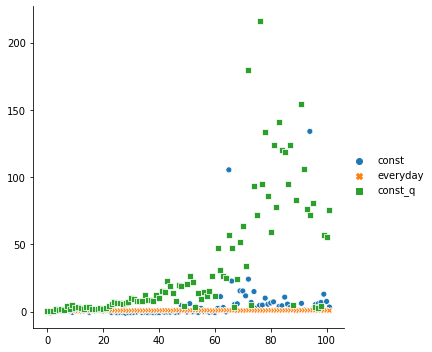

In [596]:
df = pd.DataFrame({'const':loo_const.pareto_k, 'everyday':loo_every.pareto_k, 'const_q':loo_const_q.pareto_k})
sns.relplot(data=df)

In [597]:
df.idxmax()

const       94
everyday    46
const_q     90
dtype: int64

In [598]:
def loo(sm):
    log_likelihood = 0
    for i in range(C0.shape[0]-1):
        print('\rNo, %d' % i, end='')
        data_LOO = {'T': C0.shape[0], 'T0': i+1, 'P': P, 'C0': C0, 'R0': R0, 'D0':D0}
        fit_loo = sm_const.sampling(data=data_LOO, iter=2000, init='random')
        data_loo = az.from_pystan(fit_loo, log_likelihood='log_lik')
        log_likelihood += data_loo.sample_stats['log_likelihood'].sel(log_likelihood_dim_0=i).mean()
        
    return log_likelihood

In [599]:
### Visualization ###

In [600]:
upto = epoch+pd.Timedelta(days=C0.shape[0]-2)
index= pd.date_range(start=epoch, end=upto)

In [601]:
#### Changing beta and q

In [602]:
init_inf_e = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values)
b_e = pd.DataFrame(data_every.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_e = pd.DataFrame(data_every.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
NI_e = pd.DataFrame(data_every.posterior['NI'].stack(sample=('chain', 'draw')).values, index=index)
#a_e = pd.DataFrame(data_every.posterior['a'].stack(sample=('chain', 'draw')).values)
d_e = pd.DataFrame(data_every.posterior['d'].stack(sample=('chain', 'draw')).values)
C_e = NI_e.cumsum().shift(periods=1).fillna(0)
C_e = pd.DataFrame(np.array([C_e.iloc[i].values + init_inf_e.values[i] for i in range(C_e.shape[0])]), index=index)
NI0_e = q_e*NI_e
C0S_e = NI0_e.cumsum().shift(periods=1).fillna(0)
C0S_e = pd.DataFrame(np.array([C0S_e.iloc[i].values + C0[0] for i in range(C_e.shape[0])]), index=index)

In [689]:
def draw(a, name='data', real=None, upto=pd.to_datetime('2020-04-26'), line=None):
    data=pd.DataFrame(simulated, index=pd.date_range(start=epoch, end=upto))
    print(data)
#     median = simulated.median(axis=1)
#     upper = simulated.quantile(q=0.75, axis=1)
#     lower = simulated.quantile(q=0.25, axis=1)
#     if not real is None:
#         graph['Real'] = real
#     graph['Median'] = median
#     graph['Upper'] = upper
#     graph['Lower'] = lower
    g=sns.relplot(kind="line", data=data, aspect=2)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linewidth=2, alpha=.7)
    plt.show()

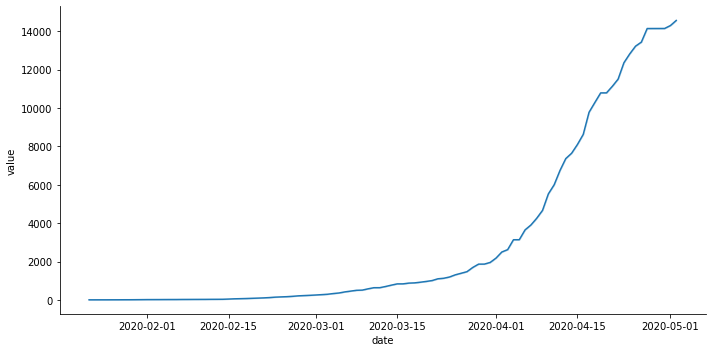

In [699]:
data=pd.DataFrame(C0S_e, index=pd.date_range(start=epoch, end=upto))
data['date']=data.index
data=pd.melt(data, id_vars=['date'])
data.rename({'value', 'Estimated'
sns.relplot(data=data, x='date', y='value', kind='line', aspect=2)

In [690]:
draw(C0S_e, real=confirmed[country])

                    0             1             2             3     \
2020-01-22      2.000000      2.000000      2.000000      2.000000   
2020-01-23      2.069289      2.065724      2.005033      2.007094   
2020-01-24      2.077161      2.295103      2.021999      2.043158   
2020-01-25      2.899647      2.322621      2.926810      2.359801   
2020-01-26      3.433774      2.951369      4.173622      2.576924   
...                  ...           ...           ...           ...   
2020-04-22  11651.726114  11612.736796  11377.493178  11509.011279   
2020-04-23  12488.664723  12516.948272  12214.479819  12377.654285   
2020-04-24  12927.318779  12962.411049  12676.294751  12828.121734   
2020-04-25  13328.776344  13383.456301  13100.050327  13229.363504   
2020-04-26  13532.852014  13586.814058  13290.947817  13468.809551   

                    4             5             6             7     \
2020-01-22      2.000000      2.000000      2.000000      2.000000   
2020-01-23      2.0

ValueError: These `style` levels are missing dashes: {6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576, 2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647, 2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862, 2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2973, 2974, 2975, 2976, 2977, 2978, 2979, 2980, 2981, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3081, 3082, 3083, 3084, 3085, 3086, 3087, 3088, 3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3219, 3220, 3221, 3222, 3223, 3224, 3225, 3226, 3227, 3228, 3229, 3230, 3231, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3249, 3250, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3270, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3315, 3316, 3317, 3318, 3319, 3320, 3321, 3322, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3506, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3522, 3523, 3524, 3525, 3526, 3527, 3528, 3529, 3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3578, 3579, 3580, 3581, 3582, 3583, 3584, 3585, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3612, 3613, 3614, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3630, 3631, 3632, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3650, 3651, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3894, 3895, 3896, 3897, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3907, 3908, 3909, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3925, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3934, 3935, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999}

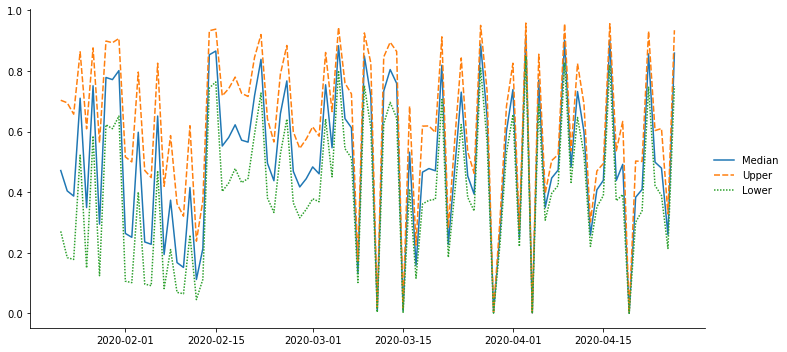

In [605]:
draw(q_e)

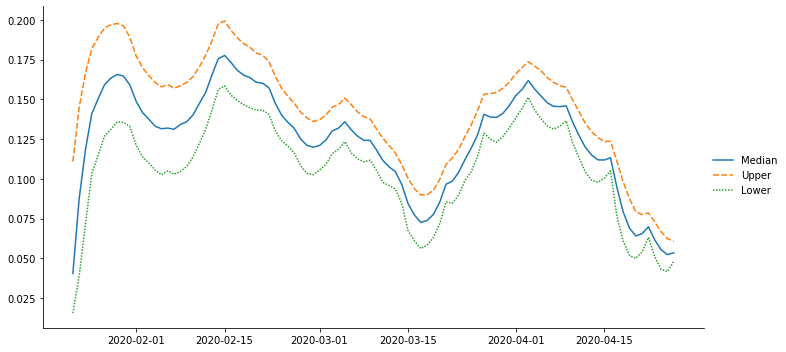

In [606]:
draw(b_e)

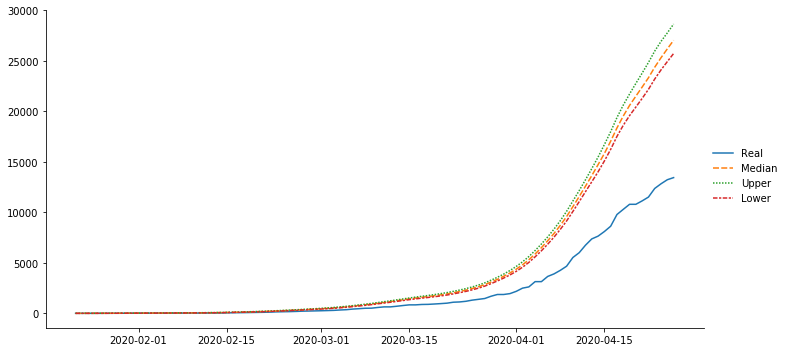

In [607]:
draw(C_e, real=confirmed[country])

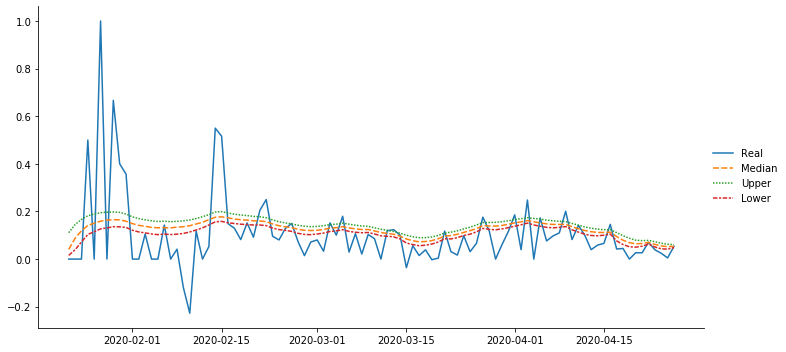

In [608]:
infected = (confirmed-recovered)[country]
r=infected.shift(-1)/infected-1
draw(b_e, real=r)

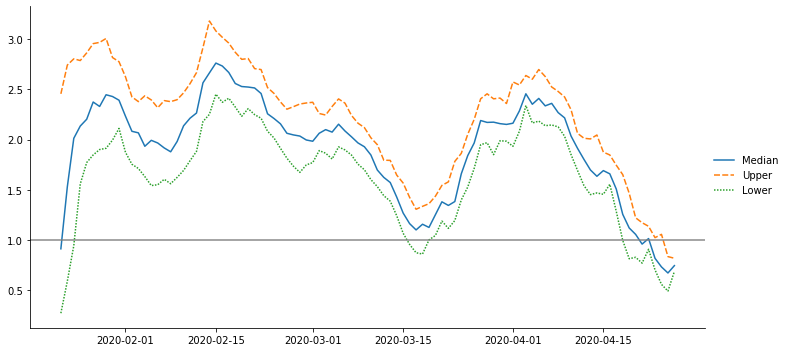

In [609]:
R = pd.DataFrame(np.array([(b_e[i].values / (a_e.iloc[i].values + 0.05)) * (1 - C_e[i]/P) for i in range(len(b_e))]).T, index=b_e.index)
draw(R, line=1)

In [610]:
## Sensibility analysis

In [611]:
data_sen = data.copy()
data_sen['b_beta_0']=1

In [612]:
# Train the model and generate samples
inits = 'random'
fit_sens = sm_every.sampling(data=data_sen, iter=iteration, init=inits)
fit_sens


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf   5.72    0.24   5.45   1.09   2.58   4.16   6.72  21.45    537    1.0
b_beta     0.02  3.7e-4 4.2e-3 8.2e-3   0.01   0.01   0.02   0.02    130   1.02
b[1]       0.07  3.0e-3   0.07 1.7e-3   0.02   0.04   0.11   0.24    520    1.0
b[2]        0.1  2.9e-3   0.07 7.6e-3   0.04   0.09   0.15   0.26    625    1.0
b[3]       0.13  2.4e-3   0.07   0.02   0.08   0.12   0.17   0.27    758    1.0
b[4]       0.15  2.5e-3   0.06   0.05   0.11   0.14   0.19   0.28    615   1.01
b[5]       0.16  2.4e-3   0.06   0.06   0.12   0.15   0.19   0.28    588   1.01
b[6]       0.17  2.3e-3   0.05   0.07   0.13   0.16    0.2   0.28    576   1.01
b[7]       0.17  2.3e-3   0.05   0.08   0.13   0.16

In [613]:
data_sens = az.from_pystan(fit_sens, log_likelihood='log_lik')

In [614]:
init_inf_sens = pd.DataFrame(data_sens.posterior['init_inf'].stack(sample=('chain', 'draw')).values)
b_sens = pd.DataFrame(data_sens.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sens = pd.DataFrame(data_sens.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)



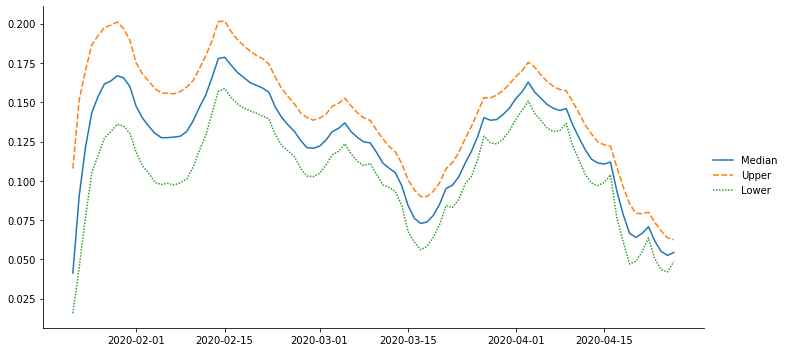

In [615]:
draw(b_sens)

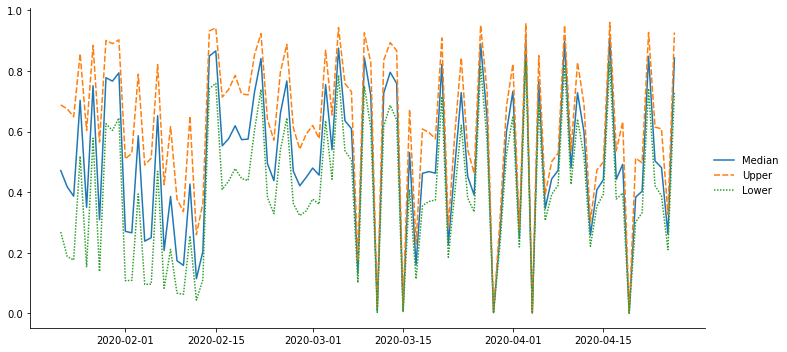

In [616]:
draw(q_sens)

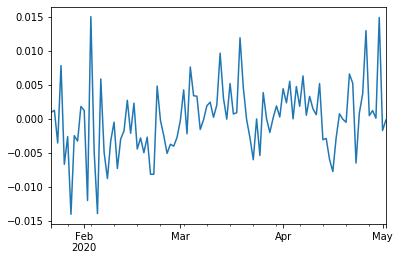

In [617]:
(q_e-q_sens).median(axis=1).plot()

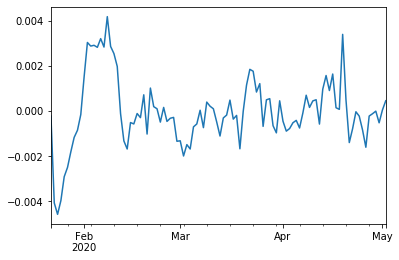

In [618]:
(b_e-b_sens).median(axis=1).plot()

In [619]:
## Validation by simualation

In [620]:
from scipy.stats import poisson
def simulate_const(b, q, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1}

In [621]:
data_sim = simulate_const(0.07, 0.2, 100, 0.04, 0.001, index)

In [622]:
data_sim

{'C0': array([ 20,  20,  20,  20,  21,  21,  23,  23,  24,  24,  25,  25,  29,
         29,  30,  32,  35,  40,  42,  45,  46,  46,  50,  53,  57,  57,
         60,  63,  68,  69,  74,  77,  81,  86,  89,  95,  97,  99, 101,
        104, 108, 119, 120, 122, 127, 131, 136, 145, 152, 161, 171, 173,
        179, 189, 192, 196, 203, 208, 212, 217, 223, 231, 239, 245, 250,
        260, 268, 274, 280, 290, 298, 305, 315, 326, 342, 357, 370, 380,
        391, 397, 406, 415, 426, 439, 450, 468, 481, 492, 512, 526, 540,
        567, 583, 600, 616, 638, 656, 675, 690, 706, 731, 750, 780]),
 'R0': array([  0,   1,   1,   4,   4,   5,   5,   5,   6,   6,   6,   6,   9,
         10,  10,  10,  12,  14,  16,  18,  20,  20,  22,  24,  25,  26,
         28,  30,  31,  32,  34,  37,  37,  38,  40,  42,  44,  46,  48,
         48,  53,  56,  57,  62,  63,  65,  69,  70,  72,  80,  84,  87,
         92,  95,  96, 103, 106, 108, 114, 114, 117, 120, 128, 134, 141,
        145, 150, 158, 165, 172, 174, 188,

In [623]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  37.67    2.86  27.18  14.69  22.34  28.71  41.65  120.2     90   1.05
b_beta   4.7e-3  2.1e-4 1.8e-3 1.6e-3 3.4e-3 4.5e-3 5.8e-3 8.8e-3     71   1.03
b[1]       0.01  2.1e-3   0.02 3.2e-4 2.9e-3 6.6e-3   0.01   0.07     70   1.06
b[2]       0.02  2.0e-3   0.02 8.7e-4 6.8e-3   0.01   0.03   0.08    106   1.04
b[3]       0.03  2.0e-3   0.02 2.9e-3   0.01   0.02   0.04   0.08    127   1.03
b[4]       0.04  1.9e-3   0.02 6.5e-3   0.02   0.03   0.05   0.09    152   1.03
b[5]       0.04  1.8e-3   0.02 8.8e-3   0.03   0.04   0.06    0.1    184   1.03
b[6]       0.05  1.7e-3   0.02   0.01   0.03   0.05   0.07    0.1    192   1.03
b[7]       0.05  1.7e-3   0.02   0.01   0.04   0.05

In [624]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

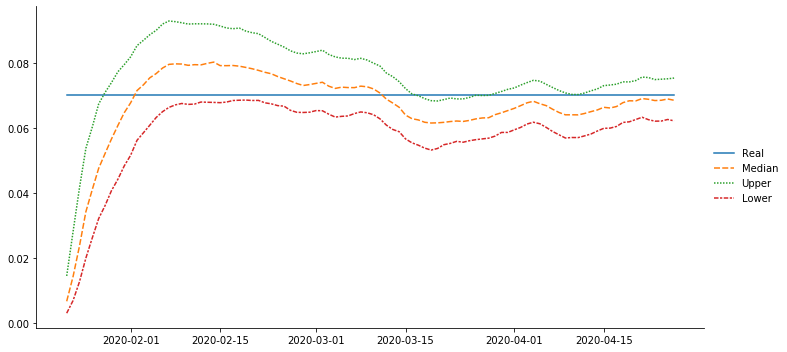

In [625]:
draw(b_sim, real=0.07)

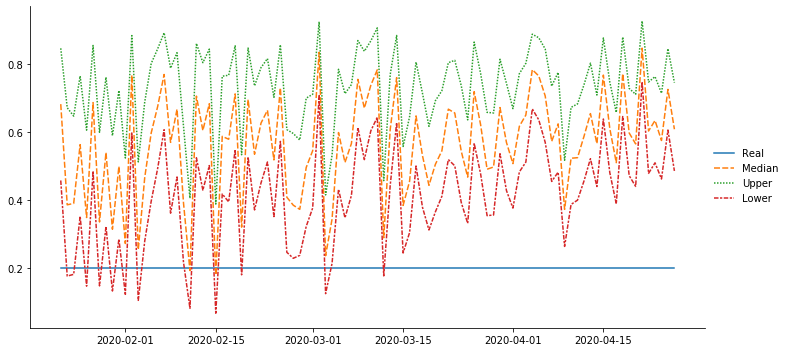

In [626]:
draw(q_sim, real=0.2)

In [627]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  18.77     0.5   4.16  11.23  15.77  18.51  21.49   27.2     70   1.06
b_beta   3.7e-3  2.9e-4 1.3e-3 1.6e-3 2.8e-3 3.6e-3 4.5e-3 6.8e-3     21   1.15
b[1]     6.7e-3  9.6e-4 8.2e-3 3.4e-4 1.8e-3 4.2e-3 8.2e-3   0.03     73   1.06
b[2]       0.01  1.3e-3   0.01 5.4e-4 4.4e-3 9.1e-3   0.01   0.04     58   1.08
b[3]       0.02  2.8e-3   0.02 1.0e-3 7.3e-3   0.01   0.02   0.06     30    1.1
b[4]       0.03  9.0e-3   0.02 5.7e-3   0.02   0.03   0.05   0.08      6   1.41
b[5]       0.04  7.6e-3   0.02 9.0e-3   0.02   0.04   0.05   0.09      8   1.34
b[6]       0.04  6.2e-3   0.02   0.01   0.03   0.04   0.06   0.09     10   1.31
b[7]       0.05  5.6e-3   0.02   0.02   0.03   0.05

In [628]:
b_sim_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)

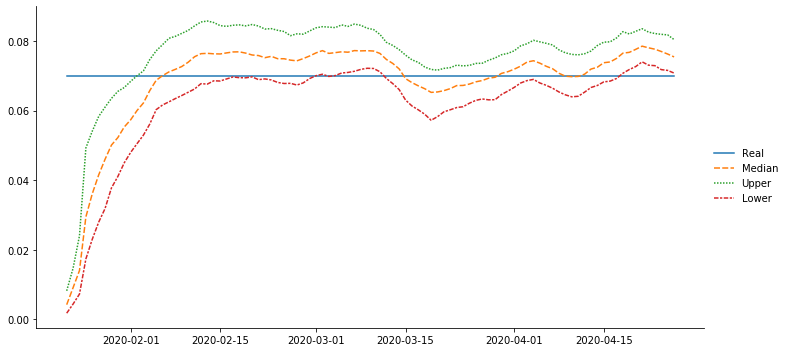

In [629]:
draw(b_sim_const_q, real=0.07)

In [630]:
from scipy.stats import poisson
def simulate_step(b, q1, q2, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    R_obs = [0]
    D_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 
            'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1, 'q':np.array(q)}

In [631]:
data_sim = simulate_step(0.07, 1, 0.8, 1000, 0.04, 0.001, index)

In [632]:
data_sim

{'C0': array([ 1006,  1062,  1149,  1217,  1279,  1356,  1443,  1519,  1598,
         1686,  1763,  1871,  1961,  2064,  2153,  2280,  2382,  2477,
         2602,  2708,  2822,  2905,  3011,  3141,  3265,  3406,  3544,
         3710,  3885,  4031,  4199,  4362,  4498,  4711,  4903,  5089,
         5249,  5430,  5625,  5812,  5999,  6201,  6424,  6657,  6848,
         7081,  7318,  7592,  7815,  8013,  8252,  8518,  8780,  9050,
         9352,  9690,  9997, 10375, 10721, 11076, 11400, 11797, 12168,
        12525, 12893, 13305, 13705, 14157, 14592, 15075, 15543, 15891,
        16298, 16700, 17096, 17508, 17909, 18297, 18790, 19302, 19775,
        20268, 20772, 21220, 21782, 22331, 22933, 23533, 24124, 24760,
        25416, 26106, 26802, 27434, 28188, 28913, 29730, 30509, 31315,
        32202, 33014, 33962, 34904]),
 'R0': array([    0,    49,    84,   127,   174,   219,   263,   303,   361,
          430,   488,   544,   586,   641,   688,   761,   826,   890,
          959,  1027,  1085

In [633]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')

In [634]:
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 1537.0   21.43 312.43 1069.9 1316.4 1460.7 1714.2 2248.1    212   1.03
b_beta   1.3e-3  9.0e-5 6.2e-4 3.7e-4 8.2e-4 1.2e-3 1.6e-3 2.7e-3     47   1.09
b[1]       0.06  4.1e-4 7.6e-3   0.05   0.06   0.06   0.07   0.08    347   1.02
b[2]       0.06  4.0e-4 7.6e-3   0.05   0.06   0.06   0.07   0.08    369   1.02
b[3]       0.06  4.0e-4 7.6e-3   0.05   0.06   0.06   0.07   0.08    362   1.02
b[4]       0.06  4.0e-4 7.6e-3   0.05   0.06   0.06   0.07   0.08    367   1.02
b[5]       0.06  3.9e-4 7.6e-3   0.05   0.06   0.06   0.07   0.08    381   1.01
b[6]       0.06  4.0e-4 7.5e-3   0.05   0.06   0.06   0.07   0.08    363   1.01
b[7]       0.06  3.8e-4 7.5e-3   0.05   0.06   0.06

In [635]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

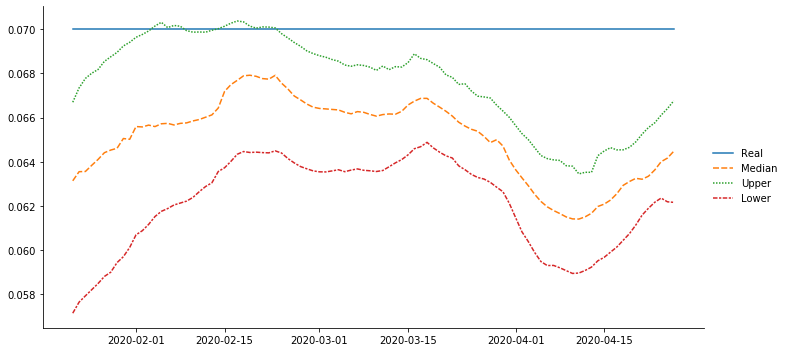

In [636]:
draw(b_sim, real=0.07)

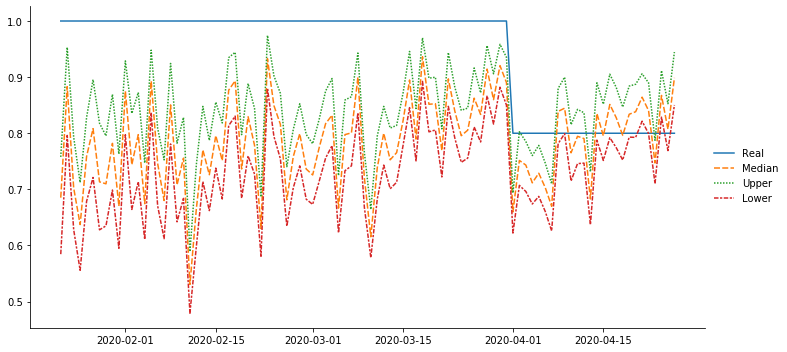

In [637]:
q = pd.Series(data_sim['q'], index)
draw(q_sim, real=q)

In [638]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 1006.4     2.7  31.74 946.87 984.53 1005.4 1026.5 1069.6    138   1.02
b_beta   1.5e-3  5.6e-5 4.6e-4 8.6e-4 1.2e-3 1.5e-3 1.8e-3 2.6e-3     67   1.05
b[1]       0.07  4.5e-4 4.9e-3   0.06   0.06   0.07   0.07   0.08    117   1.02
b[2]       0.07  3.8e-4 4.1e-3   0.06   0.06   0.07   0.07   0.07    116   1.02
b[3]       0.07  3.8e-4 3.9e-3   0.06   0.06   0.07   0.07   0.07    108   1.01
b[4]       0.07  3.4e-4 3.6e-3   0.06   0.07   0.07   0.07   0.07    111   1.01
b[5]       0.07  3.4e-4 3.4e-3   0.06   0.07   0.07   0.07   0.07    104   1.01
b[6]       0.07  3.7e-4 3.5e-3   0.06   0.07   0.07   0.07   0.08     87   1.03
b[7]       0.07  3.8e-4 3.4e-3   0.06   0.07   0.07

In [639]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)

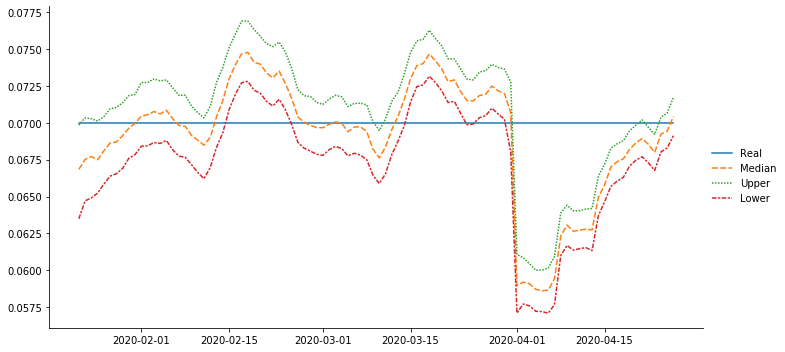

In [640]:
draw(b_const_q, real=0.07)

In [641]:
from scipy.stats import poisson
def simulate_noisy(b, q0, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        q = q0 + 0.1*np.random.randn(1)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1}

In [663]:
data_sim = simulate_noisy(0.07, 0.4, 1000, 0.04, 0.001, index)

In [664]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 652.29     8.4 173.73 426.04 523.68  616.5  741.4 1093.5    428   1.01
b_beta   2.4e-3 10.0e-5 1.0e-3 9.7e-4 1.7e-3 2.2e-3 2.9e-3 4.9e-3    105   1.02
b[1]       0.07  5.0e-4   0.01   0.04   0.06   0.07   0.08   0.09    583    1.0
b[2]       0.07  4.7e-4   0.01   0.05   0.06   0.07   0.08   0.09    655    1.0
b[3]       0.07  4.8e-4   0.01   0.05   0.06   0.07   0.08   0.09    646   1.01
b[4]       0.07  4.8e-4   0.01   0.05   0.06   0.07   0.08   0.09    617   1.01
b[5]       0.07  4.8e-4   0.01   0.05   0.06   0.07   0.08   0.09    607   1.01
b[6]       0.07  4.8e-4   0.01   0.05   0.06   0.07   0.08    0.1    597    1.0
b[7]       0.07  4.9e-4   0.01   0.05   0.06   0.07

In [665]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)

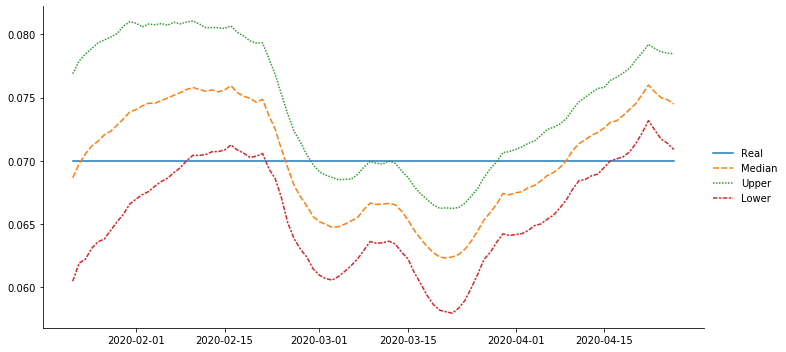

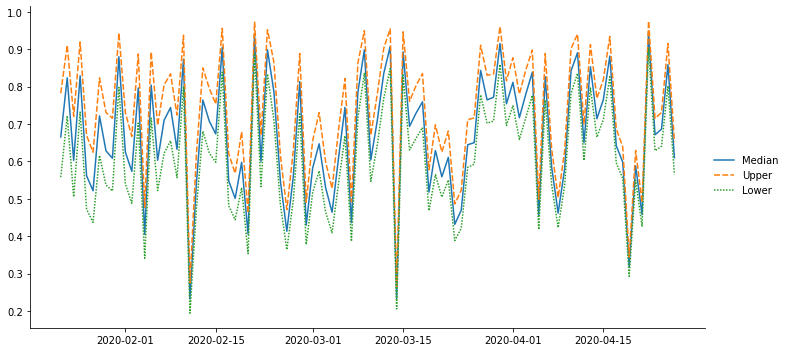

In [666]:
draw(b_sim, real=0.07)
draw(q_sim)

In [667]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 412.69    1.21  20.11 373.42 398.41 412.57 426.67 451.53    278   1.01
b_beta     0.02  1.6e-4 2.1e-3   0.01   0.01   0.02   0.02   0.02    163   1.03
b[1]       0.06  1.6e-3   0.01   0.03   0.05   0.06   0.07   0.09     91   1.04
b[2]       0.08  8.1e-4   0.01   0.05   0.07   0.08   0.08    0.1    238   1.01
b[3]       0.07  1.1e-3   0.01   0.05   0.06   0.07   0.08    0.1    143   1.02
b[4]       0.08  8.8e-4   0.01   0.05   0.07   0.08   0.09    0.1    199   1.03
b[5]       0.07  9.3e-4   0.01   0.05   0.06   0.07   0.07    0.1    170   1.02
b[6]       0.07  7.4e-4   0.01   0.05   0.06   0.07   0.07   0.09    200   1.02
b[7]       0.08  9.6e-4   0.01   0.06   0.07   0.08

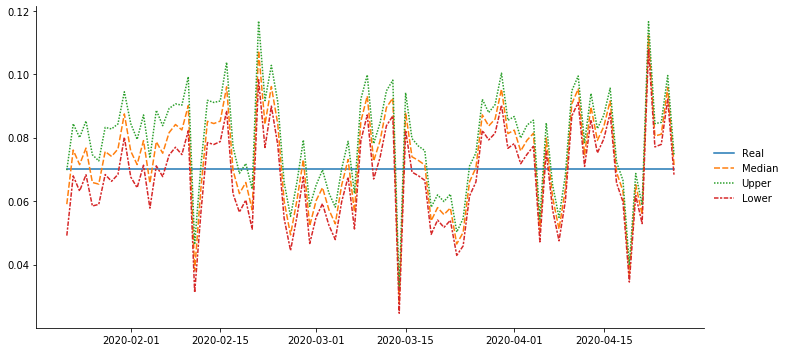

In [668]:
b_sim = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_sim, real=0.07)

In [669]:
from scipy.stats import poisson
def simulate_trend(b0, b1, q0, init_inf, a, d, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    R_obs = [0]
    D_obs = [0]
    b = [b0]
    for t in index:
        q = q0 + 0.05*np.random.randn(1)
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        b.append(b[-1] - b1)
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        R_obs.append(int(R_obs[-1]+poisson.rvs(a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
    return {'C0':np.array(C_obs), 'R0':np.array(R_obs), 'D0':np.array(D_obs), 
            'T':C0.shape[0], 'T0':0, 'P':P, 'b_beta_0':1, 'b':np.array(b)}

In [670]:
data_sim = simulate_trend(0.16, 0.001, 0.4, 1000, 0.04, 0.001, index)

In [671]:
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  547.5    3.43 113.26 389.64  462.4 527.03 612.62  814.6   1090    1.0
b_beta   3.5e-3  5.8e-5 1.0e-3 1.9e-3 2.8e-3 3.4e-3 4.1e-3 6.0e-3    325    1.0
b[1]       0.16  4.9e-4   0.02   0.13   0.15   0.16   0.17    0.2   1319    1.0
b[2]       0.16  4.9e-4   0.02   0.13   0.15   0.16   0.17   0.19   1276    1.0
b[3]       0.16  4.8e-4   0.02   0.13   0.15   0.16   0.17   0.19   1291    1.0
b[4]       0.16  4.9e-4   0.02   0.13   0.15   0.16   0.17   0.19   1199    1.0
b[5]       0.16  5.1e-4   0.02   0.12   0.14   0.16   0.17   0.19   1093    1.0
b[6]       0.16  5.0e-4   0.02   0.12   0.14   0.15   0.17   0.19   1080    1.0
b[7]       0.15  5.0e-4   0.02   0.12   0.14   0.15

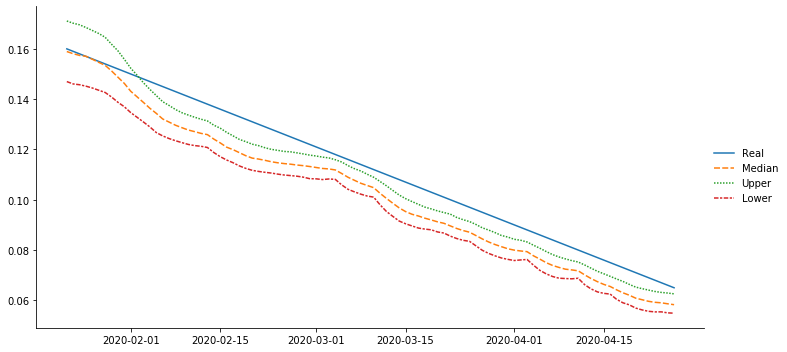

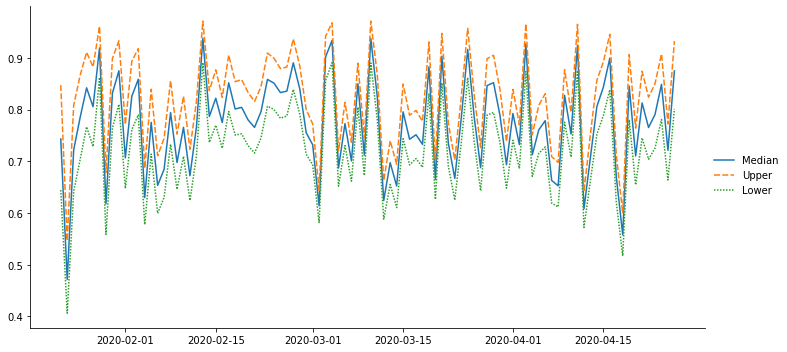

In [672]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
b = pd.Series(data_sim['b'][:-1], index)
draw(b_sim, real=b)
draw(q_sim)

In [673]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  381.3    2.11  19.45  344.2 367.51 381.23 394.03 419.14     85   1.05
b_beta     0.01  2.0e-4 1.5e-3   0.01   0.01   0.01   0.01   0.02     59   1.06
b[1]       0.16  3.1e-3   0.02   0.12   0.15   0.16   0.18    0.2     48   1.09
b[2]       0.16  5.2e-3   0.02   0.12   0.15   0.16   0.17   0.19     13   1.18
b[3]       0.17  2.2e-3   0.02   0.14   0.16   0.17   0.18    0.2     50    1.1
b[4]       0.18  1.9e-3   0.01   0.15   0.17   0.18   0.19   0.21     55   1.07
b[5]       0.18  1.2e-3   0.01   0.15   0.17   0.18   0.19   0.21    135   1.03
b[6]       0.18  9.8e-4   0.01   0.15   0.17   0.18   0.19    0.2    178   1.02
b[7]       0.18  1.2e-3   0.01   0.16   0.17   0.18

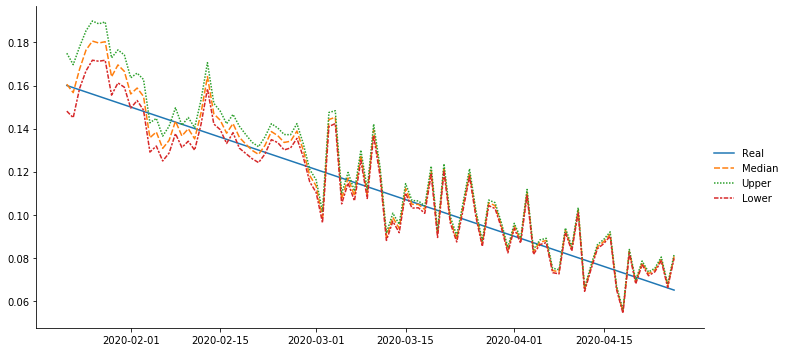

In [674]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_const_q, real=b)

In [675]:
data_sim = simulate_trend(0.01, -0.001, 0.5, 1000, 0.04, 0.001, index)

In [676]:
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 626.42    6.48  143.5 477.81 531.83 583.65  676.5 1001.1    490   1.01
b_beta   3.2e-3  3.8e-5 8.2e-4 2.0e-3 2.7e-3 3.1e-3 3.7e-3 5.1e-3    468   1.01
b[1]     6.1e-3  6.0e-5 3.9e-3 9.5e-4 3.2e-3 5.2e-3 8.2e-3   0.02   4144    1.0
b[2]       0.01  1.2e-4 5.2e-3 5.1e-3 9.6e-3   0.01   0.02   0.03   1970    1.0
b[3]       0.02  1.4e-4 5.3e-3 7.1e-3   0.01   0.02   0.02   0.03   1416    1.0
b[4]       0.02  1.5e-4 5.5e-3 6.9e-3   0.01   0.02   0.02   0.03   1402    1.0
b[5]       0.02  1.6e-4 5.7e-3 7.3e-3   0.01   0.02   0.02   0.03   1211    1.0
b[6]       0.02  1.9e-4 5.9e-3 7.5e-3   0.01   0.02   0.02   0.03   1024    1.0
b[7]       0.02  1.9e-4 6.0e-3 8.5e-3   0.01   0.02

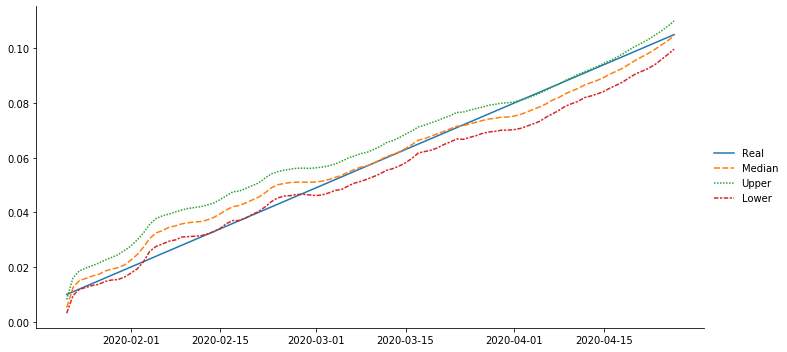

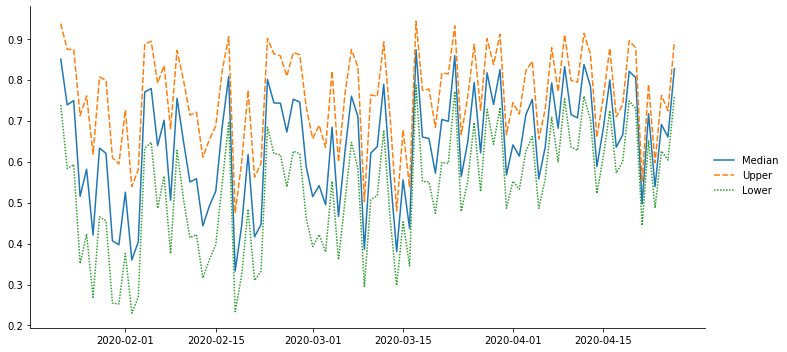

In [677]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
b = pd.Series(data_sim['b'][:-1], index)
draw(b_sim, b)
draw(q_sim)

In [678]:
# Train the model and generate samples
inits = 'random'
data_sim['q0']=1
fit_const_q = sm_const_q.sampling(data=data_sim, iter=iteration, init=inits)
inf_const_q = az.from_pystan(fit_const_q, log_likelihood='log_lik')
fit_const_q


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dd31a91ba2222187c48a952f7561ebe.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf 495.01    1.94  23.99 446.74  479.3 494.59 510.88 541.74    153   1.02
b_beta   3.6e-3  1.0e-4 8.7e-4 2.2e-3 3.0e-3 3.5e-3 4.1e-3 5.7e-3     74   1.05
b[1]     5.9e-3  3.4e-4 3.6e-3 1.2e-3 3.2e-3 5.1e-3 7.8e-3   0.02    111   1.05
b[2]       0.01  4.0e-4 4.1e-3 4.1e-3 7.8e-3   0.01   0.01   0.02    107   1.04
b[3]       0.01  4.2e-4 4.3e-3 5.5e-3 9.6e-3   0.01   0.01   0.02    104   1.02
b[4]       0.01  3.9e-4 3.7e-3 5.8e-3 9.2e-3   0.01   0.01   0.02     90   1.04
b[5]       0.01  4.4e-4 3.9e-3 5.5e-3 9.7e-3   0.01   0.01   0.02     80   1.03
b[6]       0.01  6.1e-4 4.2e-3 4.1e-3 8.6e-3   0.01   0.01   0.02     48   1.07
b[7]       0.01  4.8e-4 4.1e-3 6.3e-3   0.01   0.01

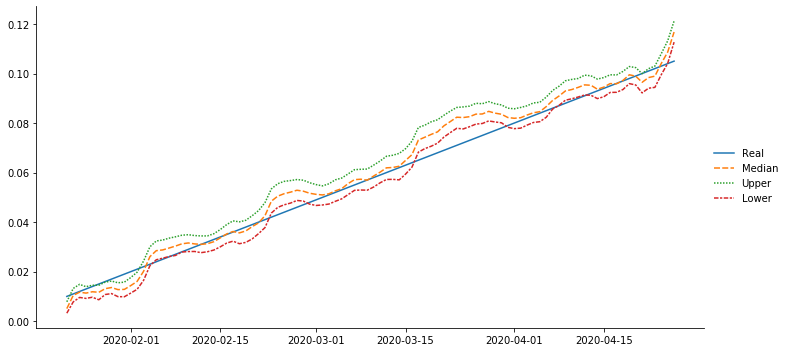

In [679]:
b_const_q = pd.DataFrame(inf_const_q.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_const_q, real=b)

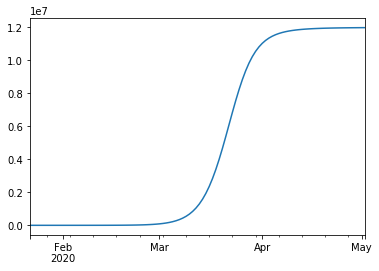

In [680]:
data_sim = simulate_const(0.3, 0.1, 100, 0.04, 0.001, index)
pd.Series(data_sim['C0'][:-1], index).plot()

In [681]:
# Train the model and generate samples
inits = 'random'
fit_sim = sm_every.sampling(data=data_sim, iter=iteration, init=inits)
inf_sim = az.from_pystan(fit_sim, log_likelihood='log_lik')
fit_sim


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_17a7257d73a110f9f91071daab0eacbd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf  11.66    0.23   3.53   6.41   9.17  11.12  13.53   20.1    227   1.01
b_beta   3.9e-3  4.1e-4 1.4e-3 1.3e-3 3.0e-3 3.8e-3 4.7e-3 7.0e-3     11    1.2
b[1]       0.29  2.0e-3   0.02   0.24   0.28   0.29   0.31   0.34    150   1.02
b[2]       0.29  2.0e-3   0.02   0.25   0.28   0.29   0.31   0.34    145   1.02
b[3]       0.29  1.9e-3   0.02   0.25   0.28   0.29   0.31   0.34    139   1.02
b[4]       0.29  1.9e-3   0.02   0.25   0.28   0.29   0.31   0.34    129   1.02
b[5]       0.29  1.9e-3   0.02   0.25   0.28   0.29   0.31   0.33    123   1.02
b[6]       0.29  1.8e-3   0.02   0.25   0.28   0.29   0.31   0.33    121   1.02
b[7]       0.29  1.7e-3   0.02   0.25   0.28   0.29

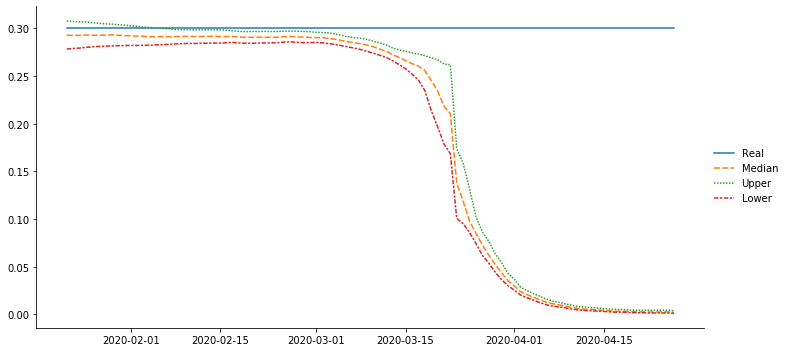

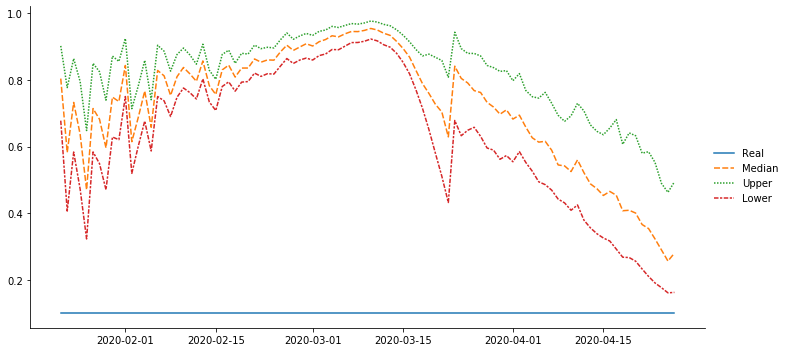

In [682]:
b_sim = pd.DataFrame(inf_sim.posterior['b'].stack(sample=('chain', 'draw')).values, index=index)
q_sim = pd.DataFrame(inf_sim.posterior['q'].stack(sample=('chain', 'draw')).values, index=index)
draw(b_sim, real=0.3)
draw(q_sim, real=0.1)